In [12]:
# Finding the pixel coordinates of a star in the image

from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astroquery.vizier import Vizier
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt

# Define the coordinates for the Eagle Nebula Pillars of Creation
# coords = SkyCoord(ra=172.63903944*u.deg, dec=48.98346557*u.deg, frame='icrs')
coords = SkyCoord('11h30m33.3694656s +48d59m00.476052s', frame='icrs')


# Get the image from SkyView
image_list = SkyView.get_images(position=coords, survey=['DSS1 Blue'], radius=0.25 * u.deg)
image_hdu = image_list[0][0]
image = image_list[0][0].data
image_hdu.header

# Extract WCS information from image
wcs = WCS(image_hdu.header)

print('*' * 10)

print("Testing with manually translated coordinates: ")
# 18184798-1354388 = 18h18m47.98s -13d54m38.8s
# c = SkyCoord("18h18m47.98s -13d54m38.8s", frame=ICRS)

# 18184744-1354414 = 18h18m47s -13d54m41s
# c = SkyCoord("18h18m47.44s -13d54m41.4s", frame=ICRS)

# 18190221-1353284 = 18h19m02.21s -13d53m28.4s
# c = SkyCoord("18h19m02.21s -13d53m28.4s", frame=ICRS)

c = SkyCoord('11h30m33.3694656s +48d59m00.476052s', frame='icrs')


test_pixel_coords = wcs.world_to_pixel(c)
print('Pixel Coords:', test_pixel_coords)

# Function that takes a wcs object and returns an array of the range of ICRS coordinates in the image
def getCoordRangeFromPixels(wcs):

    x_dim = wcs.pixel_shape[0] # May need to swap x and y dim! (but I think it's right...)
    y_dim = wcs.pixel_shape[1]

    coord_range = {}

    coord_range['lower_left'] = wcs.all_pix2world([0], [0], 1)
    coord_range['lower_right'] = wcs.all_pix2world([x_dim], [0], 1)
    coord_range['upper_left'] = wcs.all_pix2world([0], [y_dim], 1)
    coord_range['upper_right'] = wcs.all_pix2world([x_dim], [y_dim], 1)
    
    return coord_range


range = getCoordRangeFromPixels(wcs)
print('RANGE:', range)

print('*' * 10)

# NOTE: X Max and min are reversed for some reason.. orientation of image in coord system...?

x_max = range['lower_left'][0]
x_min = range['lower_right'][0]

y_min = range['lower_left'][1]
y_max = range['upper_left'][1]


def getStarsInImage(wcs, catalog):

    stars_in_image = []

    print("Number of stars in catalog query: ", len(catalog))
    
    for star in catalog.iterrows(): 

        # print('STAR:\n', star[1][0]) # REJ2000
        # print('STAR:\n', star[1][1]) # DEJ2000

        rej = star[1][0]
        dej = star[1][1]

        if rej < x_max and rej > x_min: 

            # print('Star is in x-coords')

            if dej < y_max and dej > y_min: 

                # Then star is within bounds of image! Add it to a list of stars in the image
                # print('Star is in y-coords')

                stars_in_image.append(star)


    return stars_in_image


# Fetch star data from Vizier using the 2MASS catalog
v = Vizier(columns=['*'])
v.ROW_LIMIT = -1
catalog_list = v.query_region(coords, radius=0.35 * u.deg, catalog='II/246')
catalog = catalog_list[0]

# Convert the table to a pandas DataFrame for easier manipulation
catalog = catalog.to_pandas()


stars_in_image = getStarsInImage(wcs, catalog)
# print("Stars in image: ", stars_in_image)
print("Number of cataloged stars in image: ", len(stars_in_image))

# print(300 **2)

print('*' * 15)


# Get a star from the catalog and convert is coords to pixel coords
def getPixelCoordsFromStar(star):

    star_coords = star[1]['_2MASS']

    def parseStarCoords(coords):

        if '-' in coords:

            rej, dej = coords.split('-')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '-' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        elif '+' in coords:

            rej, dej = coords.split('+')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '+' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        # print('COORDS:', rej + ' ' + dej)

        return rej + dej
    
    coords = parseStarCoords(star_coords)

    # c = SkyCoord("18h19m02.21s -13d53m28.4s", frame=ICRS)
    c = SkyCoord(coords, frame=ICRS)

    pixel_coords = wcs.world_to_pixel(c)
    # print('Pixel Coords:', pixel_coords)
    return pixel_coords

pixel_coords = getPixelCoordsFromStar(stars_in_image[1])


**********
Testing with manually translated coordinates: 
Pixel Coords: (array(149.48430033), array(149.47741291))
RANGE: {'lower_left': [array([173.01928719]), array([48.7320426])], 'lower_right': [array([172.26123956]), array([48.73205088])], 'upper_left': [array([173.02312168]), array([49.2320283])], 'upper_right': [array([172.25743055]), array([49.23203673])]}
**********
Number of stars in catalog query:  574
Number of cataloged stars in image:  394
***************


/tmp/ipykernel_1334/497659661.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rej = star[1][0]
/tmp/ipykernel_1334/497659661.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dej = star[1][1]


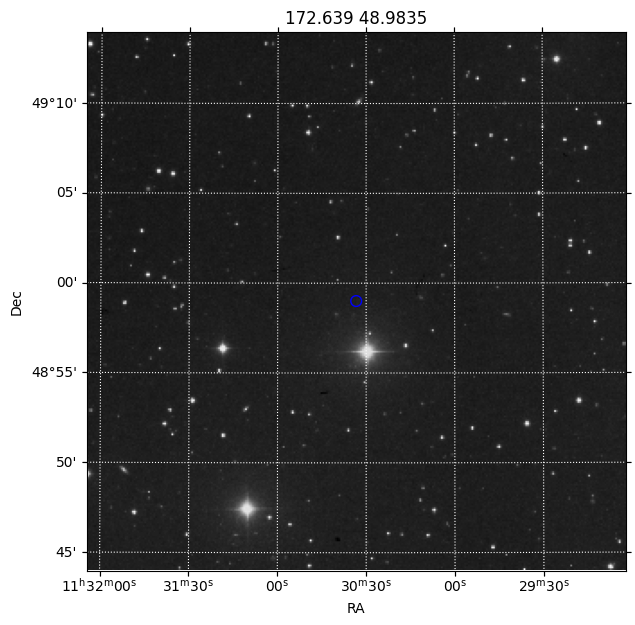

In [14]:
# Display the image with the location of the star above circled

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=wcs)

Drawing_colored_circle = plt.Circle(( test_pixel_coords[0] , test_pixel_coords[1] ), 3, fill=False, edgecolor='Blue')
ax.add_artist( Drawing_colored_circle )
ax.imshow(image_hdu.data, cmap='gray', origin='lower')
ax.set_title(f'{coords.to_string()}')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(color='white', ls='dotted')

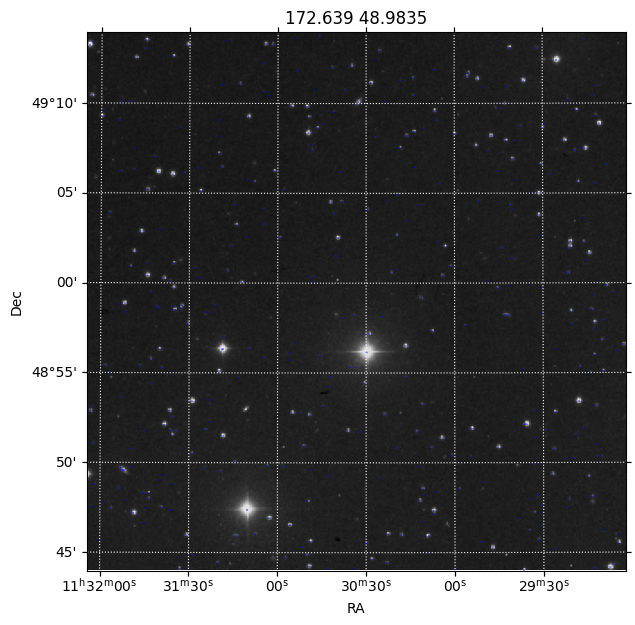

In [15]:
# Display the image with the location of the star above circled

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=wcs)

for star in stars_in_image: 

    pixel_coords = getPixelCoordsFromStar(star)
    # print('PIXEL COORDS: ', pixel_coords)

    Drawing_colored_circle = plt.Circle(( pixel_coords[0] , pixel_coords[1] ), 0.1, fill=False, edgecolor='Blue')
    ax.add_artist( Drawing_colored_circle )
    ax.set_title(f'{coords.to_string()}')
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(color='white', ls='dotted')

ax.imshow(image_hdu.data, cmap='gray', origin='lower')